In [48]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, multivariate_normal
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.parsing import preprocess_string, strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
data = fetch_20newsgroups(subset='train')
df = pd.DataFrame({
    'Data': data.data,
    'Group': data.target
})

df = df.groupby('Group', group_keys=False).apply(pd.DataFrame.sample, n=2)
df = df.sample(frac=1)

In [12]:
remove_emails = lambda s: re.sub(r'^[a-zA-Z0-9+_.-]+@[a-zA-Z0-9.-]+$', '', s)

CLEAN_FILTERS = [remove_emails, strip_tags, strip_multiple_whitespaces, strip_numeric, strip_punctuation, remove_stopwords]

def preprocessing(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

def joinList(processed_words):
    return ' '.join(processed_words)

In [34]:
cleaned_docs = []

for doc in df['Data']:
    cleaned_doc = joinList(preprocessing(doc.replace('\n', ' ')))
    cleaned_docs.append(cleaned_doc)

In [63]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words='english')
tf = tf_vectorizer.fit_transform(cleaned_docs)
vocabulary = tf_vectorizer.vocabulary_

In [96]:
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [93]:
D = len(docs)        # number of documents
W = len(vocabulary)  # size of the vocabulary 
K = 20               # number of topics

alpha = 1 / K         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / K       # the parameter of the Dirichlet prior on the per-topic word distribution

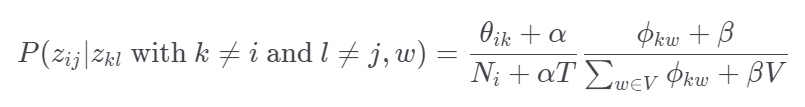

In [94]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]        # z_i_j
theta_d_z = np.zeros((D, K))
phi_z_w = np.zeros((K, W))
n_d = np.zeros((D))
n_z = np.zeros((K))

# d: doc id
for d, doc in enumerate(docs):
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = random.randint(0, K-1)
        # get the topic for word w in document doc
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        n_z[z] += 1
        n_d[d] += 1


for iteration in range(100):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word w in document doc
            z = z_d_n[d][n]
            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1
            # sample new topic from a multinomial according to our formula
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + K * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + W * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()
            # set new_z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1


Text(0.5, 1.0, 'Topic distribution $theta_i$ for document 1')

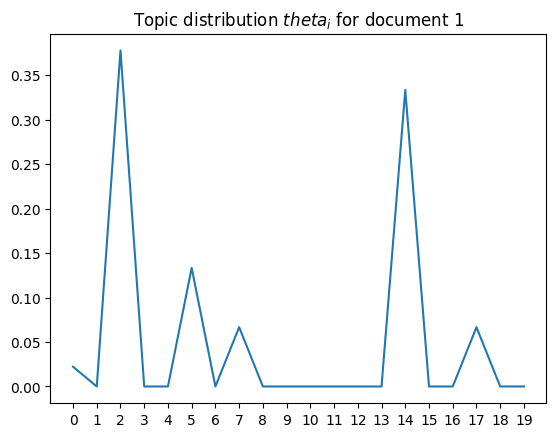

In [95]:
i = 1
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]))
plt.xticks(np.arange(0, 20, 1))
plt.title("Topic distribution $theta_i$ for document {}".format(i))

In [77]:
df

,Data,Group
7983,From: rrmadiso@undergrad.math.uwaterloo.ca (**...,10
7318,From: wgs1@Isis.MsState.Edu (Walter G. Seefeld...,6
7760,From: fisk@cvdv99.mayo.edu (Tom Fisk | 2D-337 ...,2
11086,From: cs012055@cs.brown.edu (Hok-Chung Tsang)\...,7
6647,From: hades@coos.dartmouth.edu (Brian V. Hughe...,4
10392,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...,13
11016,From: jaskew@spam.maths.adelaide.edu.au (Josep...,14
4369,From: jeh@cmkrnl.com\nSubject: Re: Need help w...,12
1715,From: cgcad@bart.inescn.pt (Comp. Graphics/CAD...,1
6522,From: kde@boi.hp.com (Keith Emmen)\nSubject: R...,16
